In [1]:
!pip install torch
!pip install transformers
!pip install numpy
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.3 MB/s eta 0:00:00


# Input Embedding

In [2]:
from transformers import BertTokenizerFast

# Intialize a tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

# Tokenize a sentence
tokens = tokenizer.tokenize("I have a new GPU!")
print('Tokens:', tokens)

# Encode a sentence
token_ids = tokenizer.encode("I have a new GPU!", return_tensors='pt')
print('Encoded:', token_ids)

Tokens: ['I', 'have', 'a', 'new', 'GP', '##U', '!']
Encoded: tensor([[  101,   146,  1138,   170,  1207, 15175,  2591,   106,   102]])


In [4]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")
model.embeddings.state_dict

<bound method Module.state_dict of BertEmbeddings(
  (word_embeddings): Embedding(28996, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)>

In [5]:
token_embeddings = model.embeddings.word_embeddings(token_ids)
print('Shape:', token_embeddings.shape)
print(token_embeddings) # shape is (batch_size, seq_len, d_model)

Shape: torch.Size([1, 9, 768])
tensor([[[ 0.0333,  0.0066, -0.0037,  ...,  0.0043, -0.0085, -0.0164],
         [-0.0307,  0.0117,  0.0386,  ...,  0.0515, -0.0519,  0.0323],
         [-0.0599,  0.0247, -0.0367,  ...,  0.0288, -0.0362,  0.0411],
         ...,
         [-0.0172,  0.0197, -0.0886,  ...,  0.0256, -0.0717, -0.0456],
         [-0.0229,  0.0417,  0.0170,  ...,  0.0349, -0.0494,  0.0097],
         [-0.0038, -0.0045,  0.0171,  ...,  0.0151, -0.0430,  0.0283]]],
       grad_fn=<EmbeddingBackward0>)


# Positional Encoding

## Plain implementation


In [5]:
# The code is adapted from https://kikaben.com/transformers-positional-encoding/

import math
import numpy as np

MAX_SEQ_LEN = 512 # maximum length of a sentence
d_model = 768 # word embedding (and positional encoding) dimensions

# pre-allocates vectors with zeros
PE = np.zeros((MAX_SEQ_LEN, d_model))

# for each position, and for each dimension
for pos in range(MAX_SEQ_LEN):
    for i in range(d_model//2):
        theta = pos / (10000 ** ((2*i)/d_model))
        PE[pos, 2*i ] = math.sin(theta)
        PE[pos, 2*i + 1] = math.cos(theta)
print('Shape:', PE.shape)
PE

Shape: (512, 768)


array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 8.41470985e-01,  5.40302306e-01,  8.28430762e-01, ...,
         9.99999994e-01,  1.02427522e-04,  9.99999995e-01],
       [ 9.09297427e-01, -4.16146837e-01,  9.27994032e-01, ...,
         9.99999978e-01,  2.04855043e-04,  9.99999979e-01],
       ...,
       [ 6.19504237e-02,  9.98079228e-01,  5.35509651e-01, ...,
         9.98574494e-01,  5.21119935e-02,  9.98641247e-01],
       [ 8.73326668e-01,  4.87135024e-01,  9.99568288e-01, ...,
         9.98568889e-01,  5.22142816e-02,  9.98635904e-01],
       [ 8.81770401e-01, -4.71678874e-01,  5.84189724e-01, ...,
         9.98563272e-01,  5.23165691e-02,  9.98630551e-01]])

## PyTorch Implementation

In [7]:
# the code is adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html

import torch
from torch import nn, Tensor

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


# pre-allocates vectors with zeros
PE2 = np.zeros((MAX_SEQ_LEN, 1, d_model))

# create a postional encoding layer
layer = PositionalEncoding(d_model=d_model, max_len=MAX_SEQ_LEN)

# run encoding
output = layer(torch.Tensor(PE2))
output

tensor([[[ 0.0000e+00,  1.1111e+00,  0.0000e+00,  ...,  1.1111e+00,
           0.0000e+00,  1.1111e+00]],

        [[ 9.3497e-01,  6.0034e-01,  9.2048e-01,  ...,  1.1111e+00,
           1.1381e-04,  1.1111e+00]],

        [[ 1.0103e+00, -4.6239e-01,  1.0311e+00,  ...,  0.0000e+00,
           0.0000e+00,  1.1111e+00]],

        ...,

        [[ 6.8834e-02,  1.1090e+00,  5.9503e-01,  ...,  1.1095e+00,
           5.7902e-02,  0.0000e+00]],

        [[ 9.7036e-01,  5.4126e-01,  1.1106e+00,  ...,  1.1095e+00,
           5.8016e-02,  1.1096e+00]],

        [[ 9.7974e-01, -5.2409e-01,  6.4908e-01,  ...,  1.1095e+00,
           5.8130e-02,  1.1096e+00]]])

# Multi-head Attention
## Scaled Dot Attention
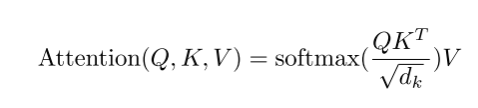


In [6]:
import math
import numpy as np

# Constant
MAX_SEQ_LEN = 10 # maximum length of a sentence
d_model = 8 # word embedding (and positional encoding) dimensions

# pre-allocates vectors with zeros
Q = np.zeros((MAX_SEQ_LEN, d_model))
K = Q
V = Q
d_k = d_model
d_v = d_model

def compute_scaled_dot_attention(Q, K, V, d_k, d_v):
  # Q.K/sqrt(d_k)
  attention_scores = np.dot(Q, np.transpose(K)) / math.sqrt(d_k)
  print('attention_scores shape', attention_scores.shape)

  # softmax
  def softmax(x):
    return np.exp(x)/sum(np.exp(x))

  final_attention_scores = np.dot(softmax(attention_scores), V)
  print('final_attention_scores shape', final_attention_scores.shape)

  return final_attention_scores

compute_scaled_dot_attention(Q, K, V, d_k, d_v)

attention_scores shape (10, 10)
final_attention_scores shape (10, 8)


array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

## Multi-Head

In [7]:
n_head = 12

Q_0 = np.zeros((MAX_SEQ_LEN, d_model))
K_0 = Q_0
V_0 = Q_0
multi_heads = []
for i in range(n_head):

  # Initialize weight matrices
  W_Q = np.zeros((d_model, d_model))
  W_K = np.zeros((d_model, d_model))
  W_V = np.zeros((d_model, d_model))

  # Linear
  Q = np.dot(Q_0, W_Q)
  K = np.dot(K_0, W_K)
  V = np.dot(V_0, W_V)

  d_k = d_model
  d_v = d_model

  print(f'Computing Head [{i}]')
  head_i = compute_scaled_dot_attention(Q, K, V, d_k, d_v)
  multi_heads.append(head_i)

# Concat all heads and do another linear transformation with W_O
# Question: what is the shape of W_O?

Computing Head [0]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [1]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [2]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [3]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [4]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [5]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [6]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [7]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [8]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [9]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [10]
attention_scores shape (10, 10)
final_attention_scores shape (10, 8)
Computing Head [11]
attention_s

Pytorch implementation of Multi-head attention: https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#MultiheadAttention

# Classification Example

In [10]:
# the code works in Python 3.6.
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

## Load the data

In [18]:
import pandas as pd

# Load the training data
df_train= pd.read_csv('train.csv', usecols=['text', 'label'])
df_train['label'] = (df_train['label'] == 'yes').astype(int)

# Load the validation data
df_val= pd.read_csv('dev.csv', usecols=['text', 'label'])
df_val['label'] = (df_val['label'] == 'yes').astype(int)

# Load the test data
df_test = pd.read_csv('test.csv', usecols=['text', 'label'])
df_test['label'] = (df_test['label'] == 'yes').astype(int)

print(f'train:{len(df_train)}, dev:{len(df_val)}, test:{len(df_test)}')
print(df_train.head())

train:7, dev:5, test:6
                                                text  label
0  Massages Can Alleviate Headaches \nWhether you...      0
1  Back in the midwest they just didn't perceive ...      1
2  The way you carry yourself, your personality,c...      0
3  NAH HOW AM I SUPPOSED TO LIVE KNOWING THAT HOB...      0
4  @UTDTrey We can all agree  now that arsenal is...      0


## Run a BERT-based classification model
### Training

In [19]:
from simpletransformers.classification import ClassificationModel

# Initialize the model
model = ClassificationModel("bert", "bert-base-cased", num_labels=2, use_cuda=True, args={'max_seq_length':128,
                                                                                          'train_batch_size': 4,
                                                                                          'overwrite_output_dir': True,
                                                                                          'num_train_epochs': 3})

# Run training
model.train_model(df_train)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/2 [00:00<?, ?it/s]

(6, 0.6348198801279068)

In [20]:
val_text=list(df_val['text'])
predictions, raw_outputs = model.predict(val_text)
print(predictions[:3])
print(raw_outputs[:3])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0 1 0]
[[-0.03372192 -0.30053711]
 [-0.16809082 -0.1628418 ]
 [ 0.04623413 -0.29345703]]
